# ML - ChatGPT

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Load the train and test datasets
train_file_path = 'train_set.csv'  # Update with your train dataset file path
test_file_path = 'test_set.csv'    # Update with your test dataset file path

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Clean and transform the MITRE Technique IDs
train_data['technique ids'] = train_data['technique ids'].apply(eval)
test_data['technique ids'] = test_data['technique ids'].apply(eval)

# Extract features from the SNORT rules using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train = tfidf_vectorizer.fit_transform(train_data['Rule'])
X_test = tfidf_vectorizer.transform(test_data['Rule'])

# Convert MITRE Technique IDs to binary format for multi-label classification
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['technique ids'])
y_test = mlb.transform(test_data['technique ids'])

# Define Binary Relevance classifiers
binary_relevance_classifiers = {
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(n_estimators=100)),
    'Support Vector Machine': OneVsRestClassifier(SVC(kernel='linear', probability=True))
}

y_pred_best = None
best_f1_score = 0
# Train and evaluate using Binary Relevance
results_binary_relevance = {}
for name, clf in binary_relevance_classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=1, output_dict=True)
    results_binary_relevance[name] = {
        'Precision': report['micro avg']['precision'],
        'Recall': report['micro avg']['recall'],
        'F1-score': report['micro avg']['f1-score']
    }

    if float(results_binary_relevance[name]['F1-score']) > best_f1_score:
        best_f1_score = results_binary_relevance[name]['F1-score']
        y_pred_best = y_pred

results_binary_relevance_df = pd.DataFrame(results_binary_relevance).T

# Display results for Binary Relevance
print("Results using Binary Relevance:")
print(results_binary_relevance_df)

# Evaluate using Classifier Chains
from sklearn.multioutput import ClassifierChain

# Define Classifier Chains classifiers
classifier_chains = {
    'Logistic Regression': ClassifierChain(LogisticRegression(max_iter=1000)),
    'Random Forest': ClassifierChain(RandomForestClassifier(n_estimators=100)),
    'Support Vector Machine': ClassifierChain(SVC(kernel='linear', probability=True))
}

# Train and evaluate using Classifier Chains
results_classifier_chains = {}
for name, clf in classifier_chains.items():
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=1, output_dict=True)
        results_classifier_chains[name] = {
            'Precision': report['micro avg']['precision'],
            'Recall': report['micro avg']['recall'],
            'F1-score': report['micro avg']['f1-score']
        }
        
        if float(results_classifier_chains[name]['F1-score']) > best_f1_score:
            best_f1_score = results_classifier_chains[name]['F1-score']
            y_pred_best = y_pred

    except Exception as e:
        print(f"Error with {name}: {e}")
        results_classifier_chains[name] = {
            'Precision': None,
            'Recall': None,
            'F1-score': None
        }

results_classifier_chains_df = pd.DataFrame(results_classifier_chains).T

# Display results for Classifier Chains
print("\nResults using Classifier Chains:")
print(results_classifier_chains_df)


Results using Binary Relevance:
                        Precision    Recall  F1-score
Logistic Regression      1.000000  0.390110  0.561265
Random Forest            0.949153  0.615385  0.746667
Support Vector Machine   0.966667  0.637363  0.768212

Results using Classifier Chains:
                        Precision    Recall  F1-score
Logistic Regression      0.925926  0.412088  0.570342
Random Forest            0.939655  0.598901  0.731544
Support Vector Machine   0.920290  0.697802  0.793750


In [33]:
print("Best F1-score:", best_f1_score)

Best F1-score: 0.7937500000000001


In [34]:
ground_truth = mlb.inverse_transform(y_test)
predictions = mlb.inverse_transform(y_pred_best)

output_df = pd.DataFrame({
    'Predicted_labels': [list(pred) for pred in predictions],
    'True_labels': [list(gt) for gt in ground_truth]
})

output_df.to_csv("ChatGPT_test_ground_truth_and_predictions.csv", index=False)
print("\nGround truth and predictions saved to test_ground_truth_and_predictions.csv")


Ground truth and predictions saved to test_ground_truth_and_predictions.csv


# CLAUDE

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler

# Function to preprocess the data (preparing features and targets)
def preprocess_data(data):
    # Split the technique IDs into separate rows
    data = data.assign(technique=data['technique ids'].str.strip('[]').str.split(', ')).explode('technique')
    data['technique'] = data['technique'].str.strip("\'")

    # Prepare the features and target
    X = data['Rule']
    y = data['technique']

    return X, y

# Load the train and test datasets
train_data = pd.read_csv('train_set.csv')  # Replace with actual path to your train data
test_data = pd.read_csv('test_set.csv')    # Replace with actual path to your test data

# Preprocess the train and test data
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

# Extract features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

# Feature selection using chi-square test
selector = SelectKBest(chi2, k=1000)
X_train_features = selector.fit_transform(X_train_features, y_train)
X_test_features = selector.transform(X_test_features)

# Handle class imbalance using random oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_features, y_train = oversampler.fit_resample(X_train_features, y_train)

# Define the models and their hyperparameters for tuning
models = [
    (SVC(kernel='linear', probability=True), {'C': [0.1, 1, 10]}),  # Set probability=True for SVM
    (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]}),
    (LogisticRegression(), {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']})
]

# Create an ensemble model using voting
ensemble = VotingClassifier(estimators=[(str(model), model) for model, _ in models], voting='soft')

# Perform grid search for hyperparameter tuning
best_model = None
best_score = 0
for model, params in models:
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1_weighted')
    grid_search.fit(X_train_features, y_train)
    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_

# Train the ensemble model
ensemble.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_features)

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print(f"\nEnsemble Model:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Make predictions using the best individual model
y_pred = best_model.predict(X_test_features)

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print(f"\nBest Model:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: Conve


Ensemble Model:
Precision: 0.8462
Recall: 0.8462
F1-score: 0.8462

Best Model:
Precision: 0.8516
Recall: 0.8516
F1-score: 0.8516


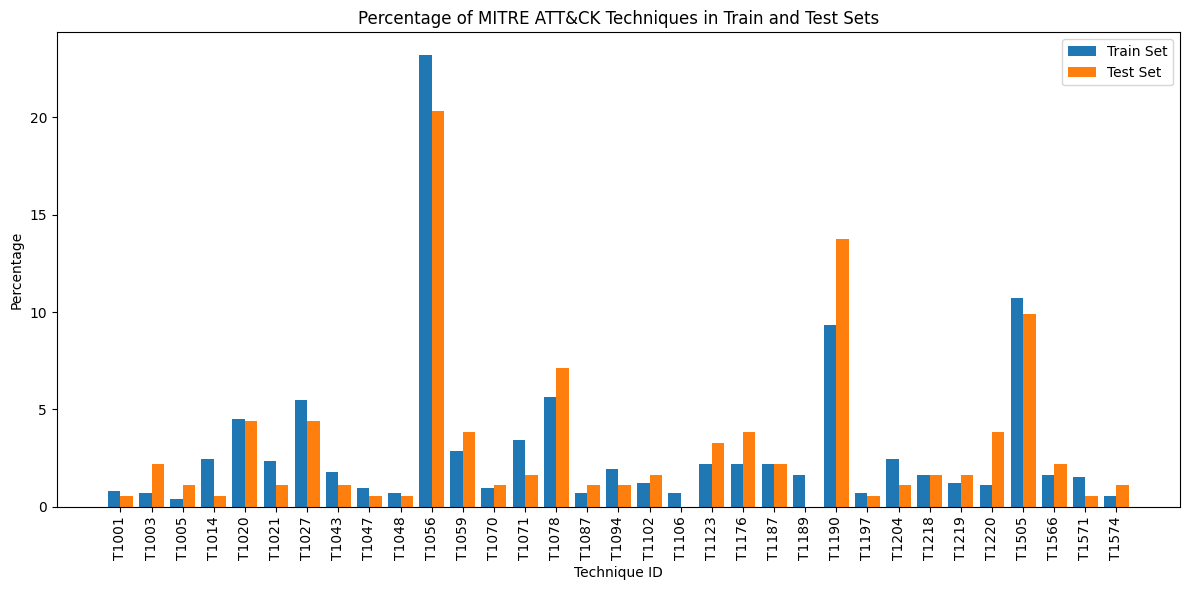

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Reload the datasets after kernel reset
claude_train_file_path = 'train_set.csv'
claude_test_file_path = 'test_set.csv'

claude_train_data = pd.read_csv(claude_train_file_path)
claude_test_data = pd.read_csv(claude_test_file_path)

# Extract technique IDs from Claude train and test data
claude_train_techniques = [tech for ids in claude_train_data['technique ids'] for tech in eval(ids)]
claude_test_techniques = [tech for ids in claude_test_data['technique ids'] for tech in eval(ids)]

# Count occurrences of each technique
claude_train_counts = Counter(claude_train_techniques)
claude_test_counts = Counter(claude_test_techniques)

# Combine counts to find all unique techniques
all_claude_techniques = set(claude_train_counts.keys()).union(claude_test_counts.keys())

# Compute percentages for each technique
claude_train_percentages = {tech: (claude_train_counts[tech] / len(claude_train_techniques)) * 100 for tech in all_claude_techniques}
claude_test_percentages = {tech: (claude_test_counts[tech] / len(claude_test_techniques)) * 100 for tech in all_claude_techniques}

# Sort techniques for consistent charting
sorted_claude_techniques = sorted(all_claude_techniques)

# Prepare data for plotting
claude_train_values = [claude_train_percentages.get(tech, 0) for tech in sorted_claude_techniques]
claude_test_values = [claude_test_percentages.get(tech, 0) for tech in sorted_claude_techniques]

# Plot bar chart
plt.figure(figsize=(12, 6))
x = range(len(sorted_claude_techniques))
plt.bar(x, claude_train_values, width=0.4, label='Train Set', align='center')
plt.bar([i + 0.4 for i in x], claude_test_values, width=0.4, label='Test Set', align='center')
plt.xticks([i + 0.2 for i in x], sorted_claude_techniques, rotation=90)
plt.ylabel('Percentage')
plt.xlabel('Technique ID')
plt.title('Percentage of MITRE ATT&CK Techniques in Train and Test Sets')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

# Load train and test datasets
train_data = pd.read_csv('train_set.csv')
test_data = pd.read_csv('test_set.csv')

# Split the technique IDs into separate rows
train_data = train_data.assign(technique=train_data['technique ids'].str.strip('[]').str.split(', ')).explode('technique')
train_data['technique'] = train_data['technique'].str.strip("\'")

# Split the technique IDs into separate rows
test_data = test_data.assign(technique=test_data['technique ids'].str.strip('[]').str.split(', ')).explode('technique')
test_data['technique'] = test_data['technique'].str.strip("\'")

# Extract features and target for training and testing
X_train = train_data['Rule']
y_train = train_data['technique']
X_test = test_data['Rule']
y_test = test_data['technique']

print(X_test)
print(y_test)


# Extract features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

# Feature selection using chi-square test
selector = SelectKBest(chi2, k=1000)
X_train_features = selector.fit_transform(X_train_features, y_train)
X_test_features = selector.transform(X_test_features)

# Handle class imbalance using random oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_features, y_train = oversampler.fit_resample(X_train_features, y_train)

# Define the models and their hyperparameters for tuning
models = [
    (SVC(kernel='linear', probability=True), {'C': [0.1, 1, 10]}),  # Set probability=True for SVM
    (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]}),
    (LogisticRegression(), {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']})
]

# Create an ensemble model using voting
ensemble = VotingClassifier(estimators=[(str(model), model) for model, _ in models], voting='soft')

# Perform grid search for hyperparameter tuning
best_model = None
best_score = 0
for model, params in models:
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1_weighted')
    grid_search.fit(X_train_features, y_train)
    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_

# Train the ensemble model
ensemble.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_features)

# Calculate evaluation metrics for the ensemble model
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print(f"\nEnsemble Model:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Evaluate the best individual model
y_pred_best = best_model.predict(X_test_features)
precision_best = precision_score(y_test, y_pred_best, average='micro')
recall_best = recall_score(y_test, y_pred_best, average='micro')
f1_best = f1_score(y_test, y_pred_best, average='micro')

print(f"\nBest Model:")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1-score: {f1_best:.4f}")


0      alert tcp any 445 -> any any ( msg:"INDICATOR-...
1      alert tcp $EXTERNAL_NET any -> $HTTP_SERVERS $...
2      alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP...
3      alert tcp $HOME_NET any -> $EXTERNAL_NET 25 ( ...
4      alert tcp $HOME_NET any -> $EXTERNAL_NET 25 ( ...
                             ...                        
177    alert tcp $HOME_NET any -> $EXTERNAL_NET $HTTP...
178    alert tcp any 445 -> any any ( msg:"INDICATOR-...
179    alert tcp $EXTERNAL_NET any -> $SMTP_SERVERS 2...
180    alert tcp $HOME_NET any -> $EXTERNAL_NET 25 ( ...
181    alert tcp $EXTERNAL_NET $FILE_DATA_PORTS -> $H...
Name: Rule, Length: 182, dtype: object
0      T1187
1      T1190
2      T1078
3      T1056
4      T1056
       ...  
177    T1094
178    T1187
179    T1220
180    T1056
181    T1059
Name: technique, Length: 182, dtype: object


C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\nirda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: Conve


Ensemble Model:
Precision: 0.8516
Recall: 0.8516
F1-score: 0.8516

Best Model:
Precision: 0.8571
Recall: 0.8571
F1-score: 0.8571


In [ ]:
# Save ground truth and predictions to a CSV file
# ground_truth = mlb.inverse_transform(y_test)
# predictions = mlb.inverse_transform(y_pred)

output_df = pd.DataFrame({
    'Predicted_labels': [f'[\'{x}\']' for x in y_pred_best],
    'True_labels': [f'[\'{x}\']' for x in y_test]
})

output_df.to_csv("Claude_test_ground_truth_and_predictions.csv", index=False)
print("\nGround truth and predictions saved to test_ground_truth_and_predictions.csv")


Ground truth and predictions saved to test_ground_truth_and_predictions.csv


# GEMINI

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import numpy as np
import ast

# Read the pre-split train and test data into DataFrames
train_df = pd.read_csv('train_set.csv') 
test_df = pd.read_csv('test_set.csv') 

# Ensure the `MITRE Technique ID` column is converted to a list of strings if necessary
train_df['technique ids'] = train_df['technique ids'].apply(lambda x: ast.literal_eval(x))
test_df['technique ids'] = test_df['technique ids'].apply(lambda x: ast.literal_eval(x))

# If necessary, explode the train and test DataFrames to handle multi-label rows
train_df = train_df.explode('technique ids').reset_index(drop=True)
test_df = test_df.explode('technique ids').reset_index(drop=True)

# Create a TF-IDF vectorizer to convert the text data in the `Rule` column into numerical features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Transform the training and test data using the TF-IDF vectorizer
X_train = tfidf_vectorizer.fit_transform(train_df['Rule'])
X_test = tfidf_vectorizer.transform(test_df['Rule'])
y_train = train_df['technique ids']
y_test = test_df['technique ids']

# Initialize a dictionary to store the results of different models
results = {}

# Define a list of models to evaluate, including OneVsRestClassifier with Logistic Regression, LinearSVC, and RandomForestClassifier as base estimators
models = [
    ('OVR Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000))),
    ('OVR Linear SVC', OneVsRestClassifier(LinearSVC(random_state=42))),
    ('OVR Random Forest', OneVsRestClassifier(RandomForestClassifier(random_state=42)))
]

y_pred_best = None
f1_best = 0
# Iterate through the models
for name, model in models:
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set and calculate precision, recall, and F1-score (weighted)
    y_pred = model.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
    if f1_score > f1_best:
        f1_best = f1_score
        y_pred_best = y_pred

    # Store the results in the `results` dictionary
    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

# Create a DataFrame from the `results` dictionary and sort it by F1-score in descending order
results_df = pd.DataFrame(results).transpose().sort_values(by='F1-Score', ascending=False)

# Print the sorted results
print(results_df.to_markdown(numalign="left", stralign="left"))


|                         | Precision   | Recall   | F1-Score   |
|:------------------------|:------------|:---------|:-----------|
| OVR Linear SVC          | 0.868132    | 0.868132 | 0.868132   |
| OVR Random Forest       | 0.835165    | 0.835165 | 0.835165   |
| OVR Logistic Regression | 0.648352    | 0.648352 | 0.648352   |


In [26]:
# Save ground truth and predictions to a CSV file
# ground_truth = mlb.inverse_transform(y_test)
# predictions = mlb.inverse_transform(y_pred_best)

output_df = pd.DataFrame({
    'Predicted_labels': [f'[\'{pred}\']' for pred in y_pred_best],
    'True_labels': [f'[\'{gt}\']' for gt in y_test]
})

output_df.to_csv("Gemini_test_ground_truth_and_predictions.csv", index=False)
print("\nGround truth and predictions saved to test_ground_truth_and_predictions.csv")


Ground truth and predictions saved to test_ground_truth_and_predictions.csv
